# 0.0 Imports

In [93]:
import pandas as pd
import inflection 
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import random
import pickle
#import warning
import xgboost as xgb
    
from boruta import BorutaPy    
from scipy import stats
from tabulate import tabulate
from IPython.core.display import HTML
from IPython.display import Image
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor

#warnings.filterwarnings( 'ignore' )

## 0.1 Helper Functions

In [101]:
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2cor = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcor = k - (k-1)**2/(n-1)
    rcor = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2cor/n) / (min(kcor-1,rcor-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y-yhat)/y))

def ml_error(model_name, y,yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index = [0])

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

Populating the interactive namespace from numpy and matplotlib


C:\Users\bruno\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['grid', 'f', 'axes', 'random', 'var']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Loading Data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on='Store')

# 1.0 Descrição dos Dados

In [4]:
df1 = df_raw.copy()

In [5]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1  Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore( x )
cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2  Data Dimensions

In [7]:
print('Number of Rows: {}'. format(df1.shape[0]))
print('Number of Columns: {}'. format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3 

In [8]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [11]:
df1['competition_distance'].max()

75860.0

In [12]:
df1.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
626679,835,2,2013-12-17,7554,850,1,1,0,0,a,a,2890.0,12.0,2007.0,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
264210,857,2,2014-12-02,9293,1059,1,1,0,0,c,a,6270.0,8.0,2005.0,1,23.0,2014.0,"Mar,Jun,Sept,Dec"
502284,205,1,2014-04-07,5480,821,1,0,0,0,a,a,110.0,12.0,2007.0,0,NaN,NaN,NaN
792778,799,7,2013-07-21,0,0,0,0,0,0,a,c,2700.0,NaN,NaN,0,NaN,NaN,NaN
792089,110,7,2013-07-21,0,0,0,0,0,0,a,c,46590.0,4.0,2013.0,0,NaN,NaN,NaN


In [13]:
#competition_distance 
df1.competition_distance.fillna(200000., inplace=True)   

#competition_open_since_month 
df1.competition_open_since_month.fillna(df1.date.dt.month, inplace=True)

#competition_open_since_year
df1.competition_open_since_year.fillna(df1.date.dt.year, inplace=True)

#promo2_since_week
df1.promo2_since_week.fillna(df1.date.dt.week, inplace=True)

#promo2_since_year
df1.promo2_since_year.fillna(df1.date.dt.year, inplace=True)

#promo_interval   
df1['promo_interval'].fillna('', inplace=True) 

# obtem a abreviatura do mês
df1['month_map'] = df1['date'].dt.strftime("%b") 

# como não tem 0's mais, tudo vai ser string, então podemos remover aqueles if's
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: x['month_map'] in x['promo_interval'].split( ',' ), axis='columns').astype('int')

In [14]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

df1['is_promo'] = df1['is_promo'].astype('int64')

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [17]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [18]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# Concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


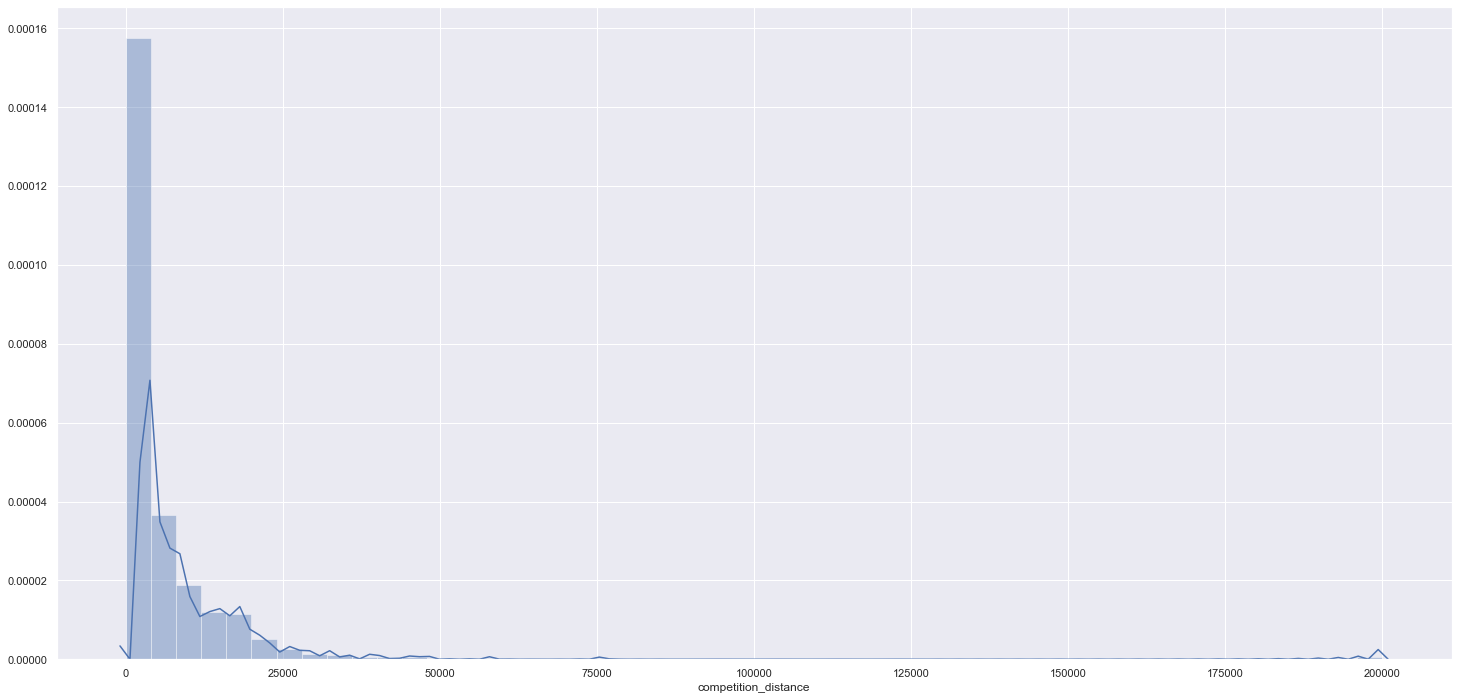

In [19]:
sns.distplot(df1['competition_distance'])

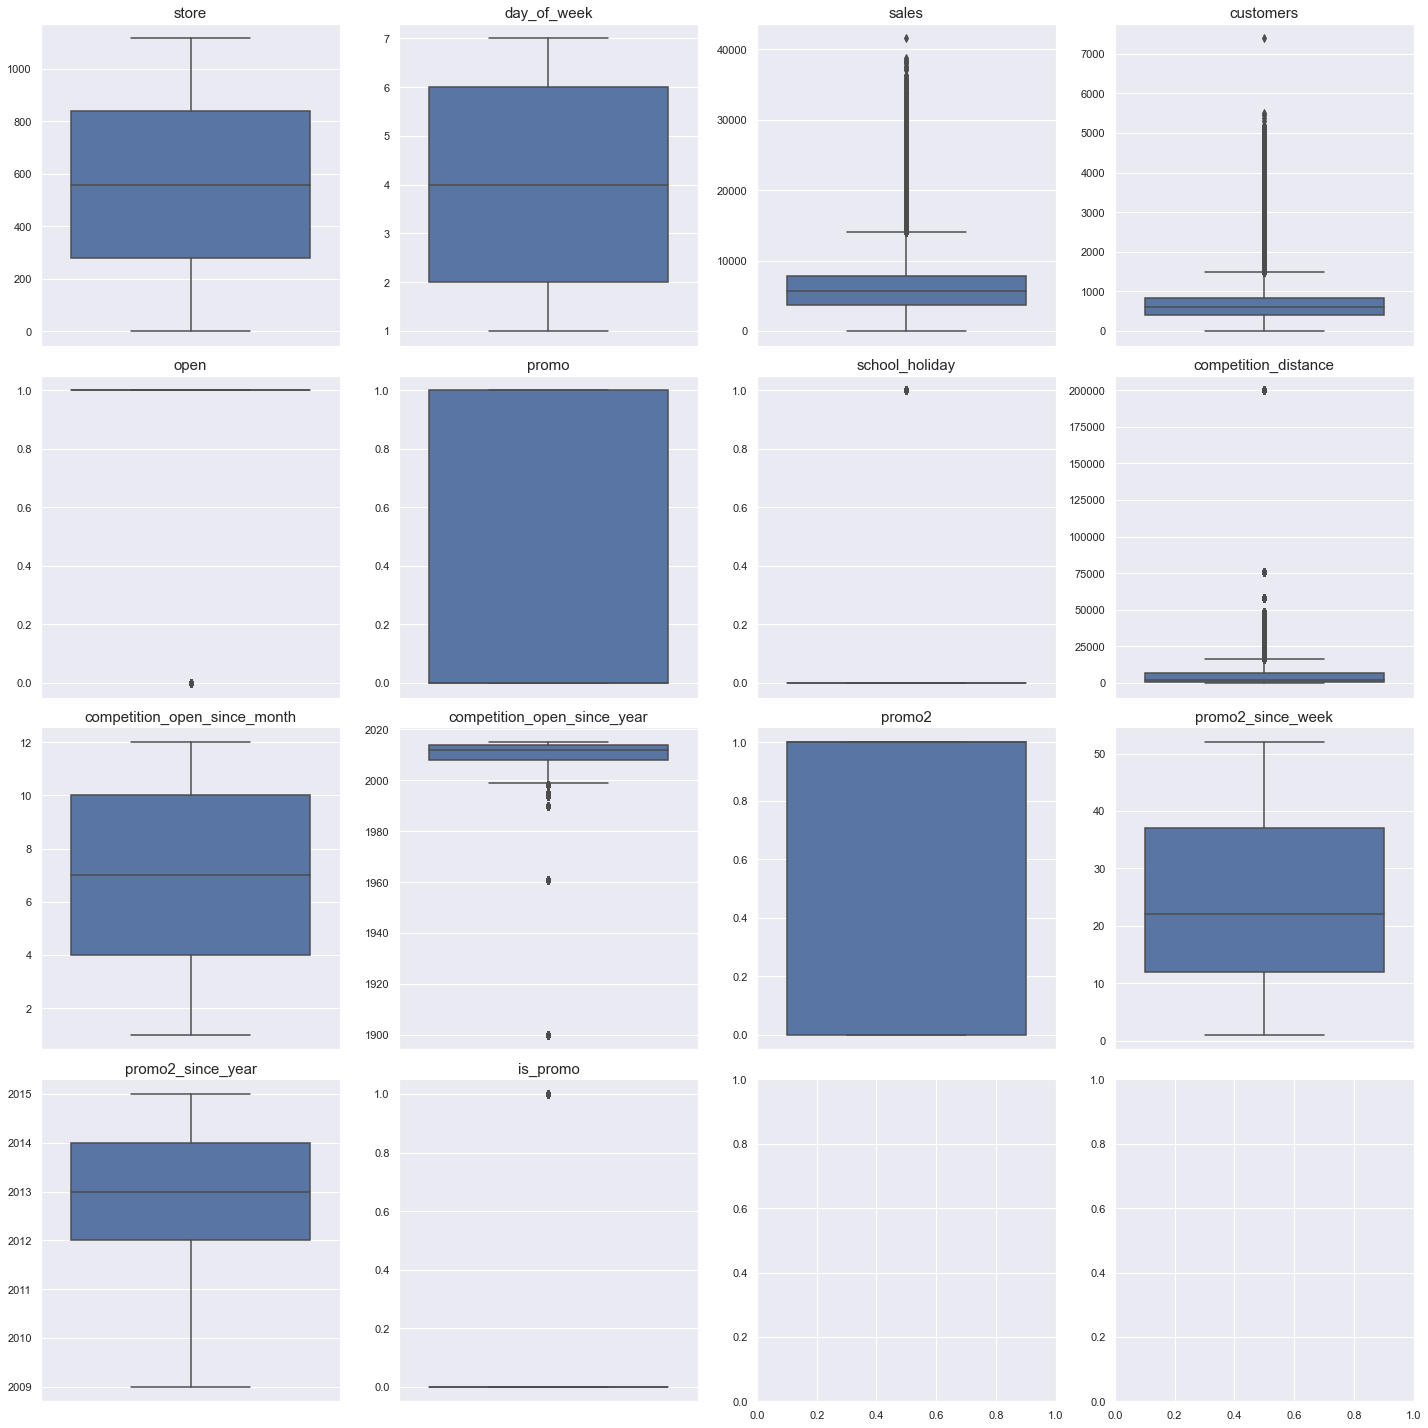

In [20]:
variables = num_attributes.columns.tolist()

f, axes = plt.subplots(4, 4, figsize = (20, 20))
for var, ax in zip(variables, f.axes):

  b = sns.boxplot(y = var, data = num_attributes, ax = ax)
  b.axes.set_title(var,fontsize = 15)
  b.set_ylabel("")

plt.tight_layout()
plt.show()

### 1.7.2 Categorical Attributes 

In [21]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

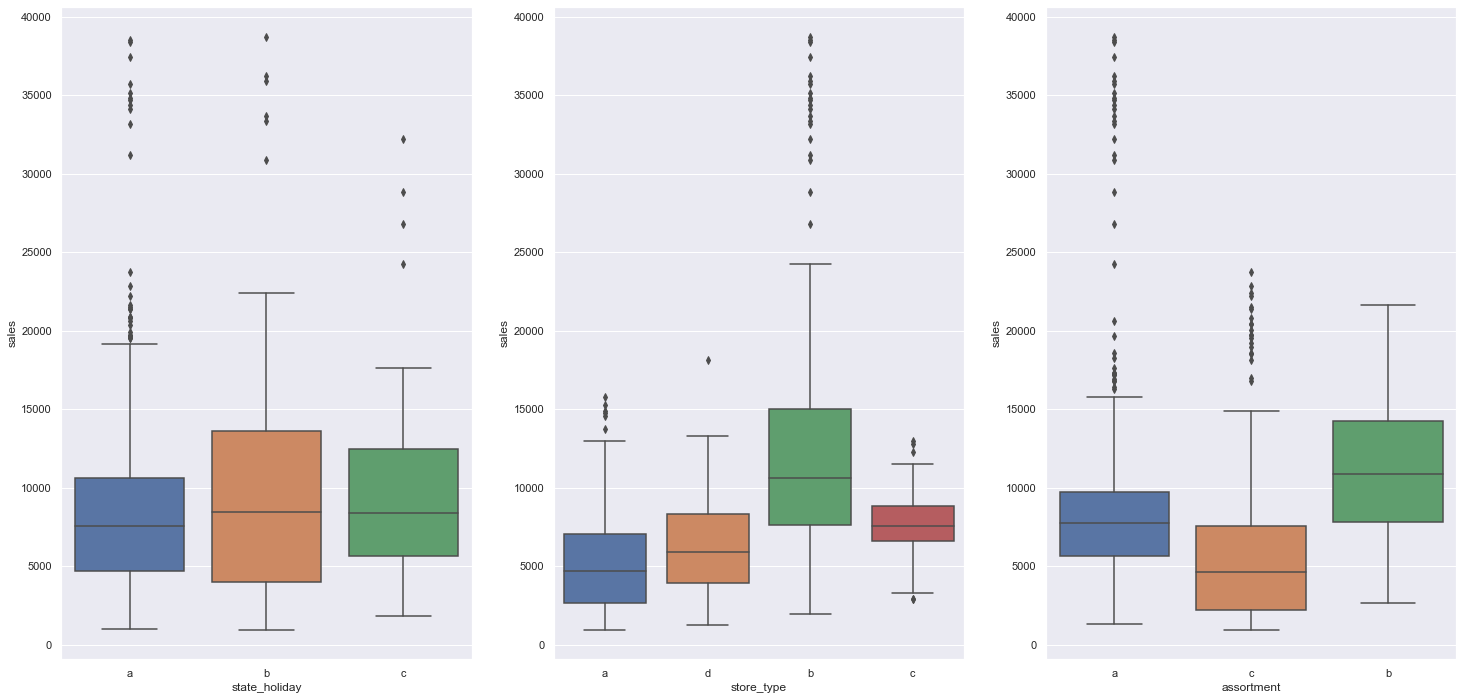

In [22]:
aux1 = df1[(df1['state_holiday'] !='0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux1)

# 2.0 Feature Engineering

In [23]:
df2 = df1.copy()

## 2.1 Mapa mental de hipóteses

<img src="img/MindMapHypotesis_.png">

In [24]:
Image('img/MindMapHypotesis.png')

FileNotFoundError: No such file or directory: 'img/MindMapHypotesis.png'

FileNotFoundError: No such file or directory: 'img/MindMapHypotesis.png'

<IPython.core.display.Image object>

## 2.2 Criação de Hipóteses

### 2.2.1 Hipóteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais distantes deveriam vender mais.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2 Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expoem mais os produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menos nos produtos deveriam vender mais.

**4.** Lojas que tem preços menores por mais tempo nos produtos deveriam vender mais.

**5.** Lojas com promoções mais agressivas (desconto maiores) deveriam vender mais.

**6.** Lojas com promoções ativas por mais temmpo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês

**5.** Lojas deveriam vender menos aos finais de semana

**6.** Lojas deveriam vender menos durantes feriados escolares

## 2.3 Lista de hipótese final

As hipóteses foram escolhidas com base nos dados que já foram obtidos e podem ser usados para estudo. Para que outras hipóteses sejam testadas é necessário que haja uma coleta maior de dados de diferentes áreas da empresa

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais distantes deveriam vender mais.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais temmpo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês

**11.** Lojas deveriam vender menos aos finais de semana

**12.** Lojas deveriam vender menos durantes feriados escolares

## 2.4 Feature Engineering

In [25]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since']=df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1),axis =1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ( (df2['date'] - df2['promo_since'])/7 ).apply(lambda x: x.days).astype('int64')

# assortment 
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x =='a' else 'extra' if x =='b' else 'extended' )
 
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x =='a' else 'easter_holiday' if x =='b' else 'christmas' if x =='c' else 'regular_day')



In [26]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Filtragem de Variáveis

In [27]:
df3 = df2.copy()

In [28]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das linhas

In [29]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]
# as linhas cuja coluna open é igual a zero, já que não contribui para obtenção de conhecimento dos dados.

## 3.2 Seleção das colunas

In [30]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop,axis = 1)

# Não tem os dados de costumers no momento da predição, é uma restrição de negócio.

In [31]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Análise exploratória dos dados

In [32]:
df4 = df3.copy() 

## 4.1 Análise Univariada

### 4.1.1 Response Variable

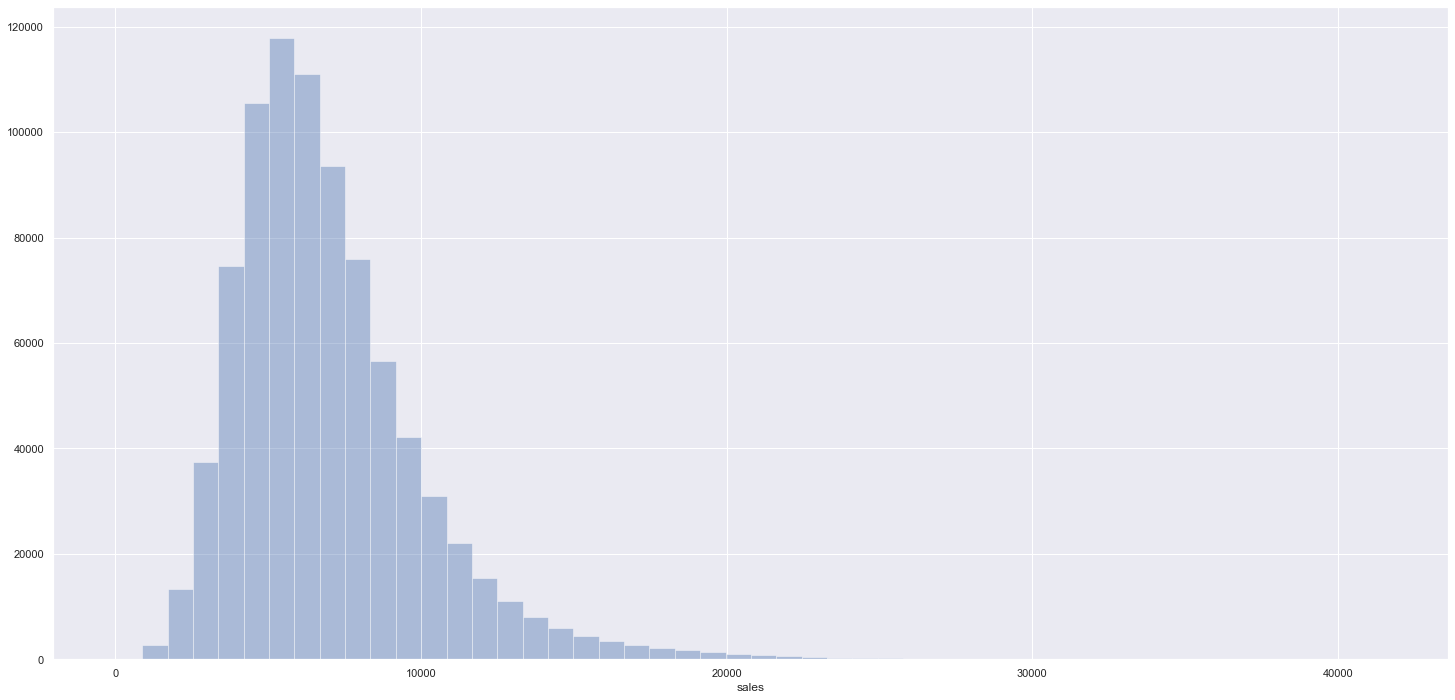

In [33]:
sns.distplot(df4['sales'], kde =False)

# quanto mais normal for a distribuição, melhor será os modelos de ML

### 4.1.2 Numerical Variable

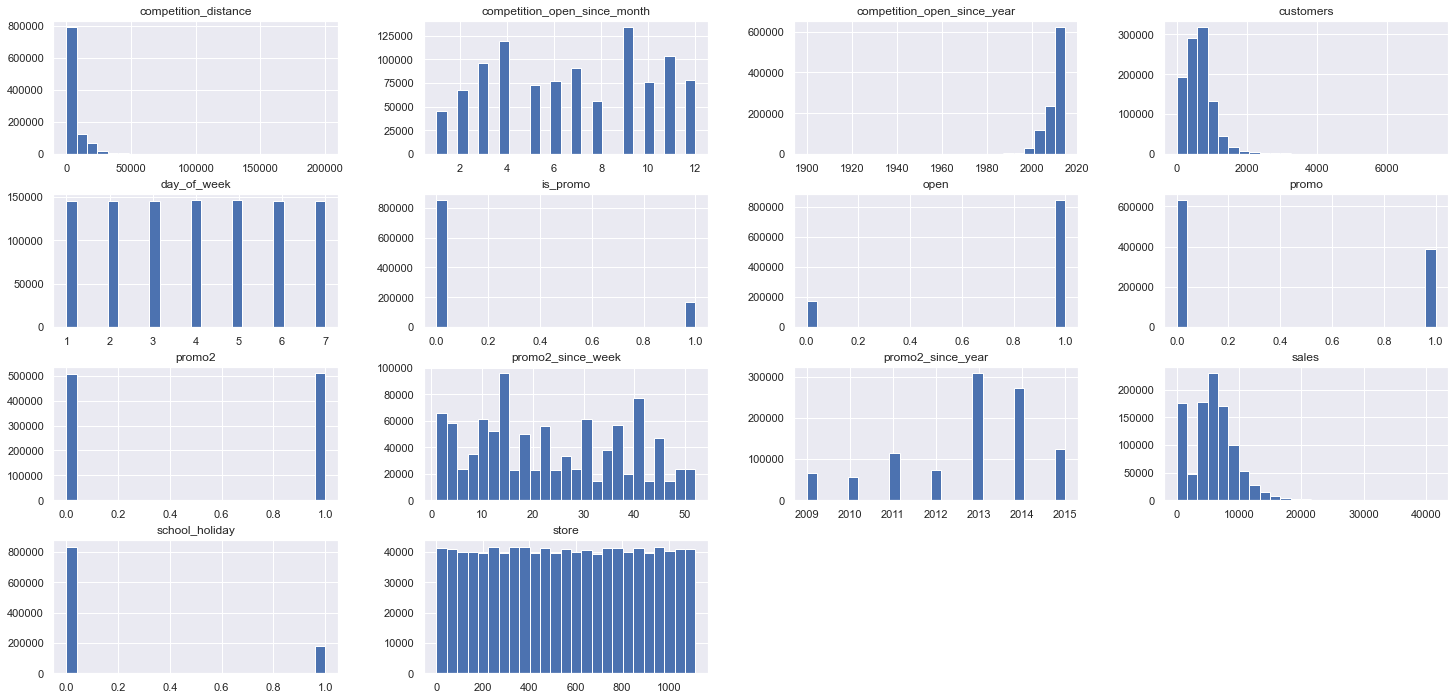

In [34]:
num_attributes.hist(bins = 25);

### 4.1.3 Categorical Variable

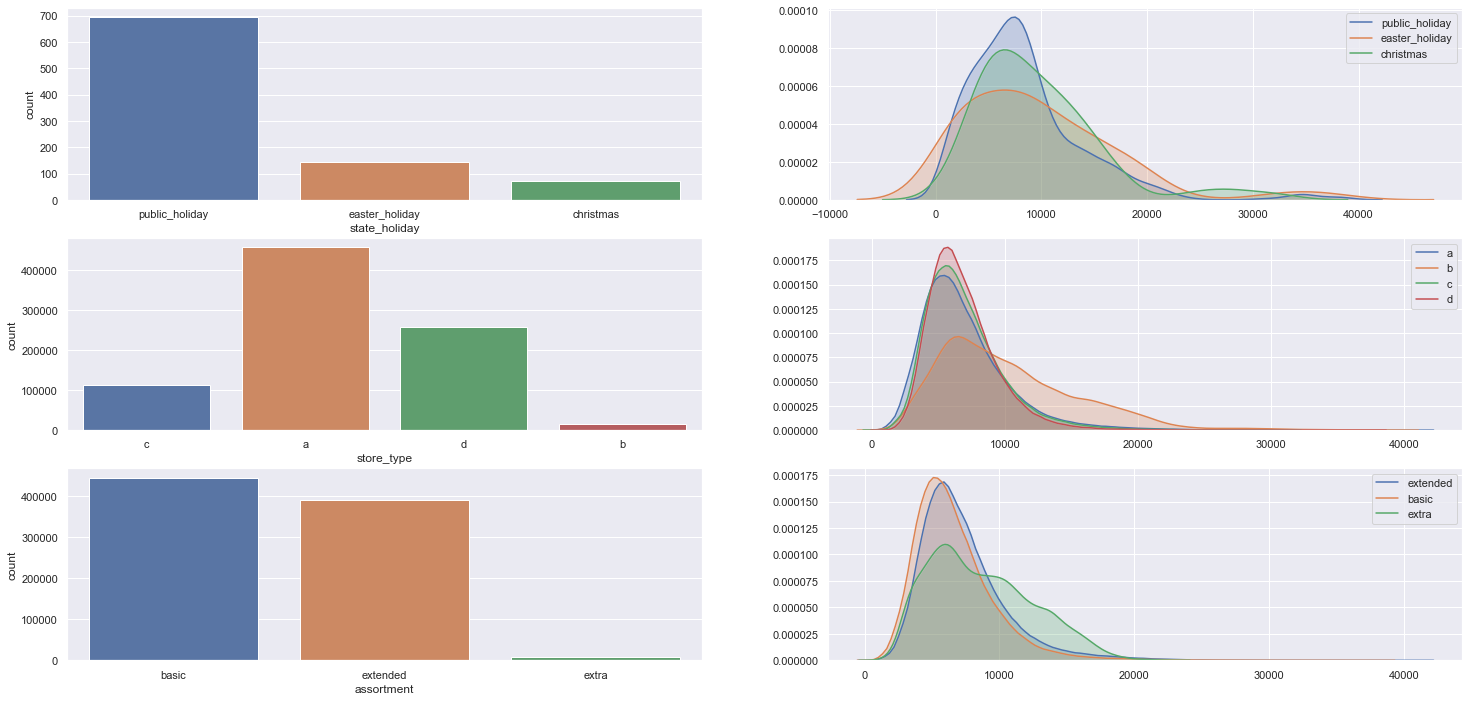

In [35]:
# state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade = True)

#store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True)

# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True)

## 4.2 Análise Bivariada

### **H1** Lojas com maior sortimento deveriam vender mais.
**Verdadeira**


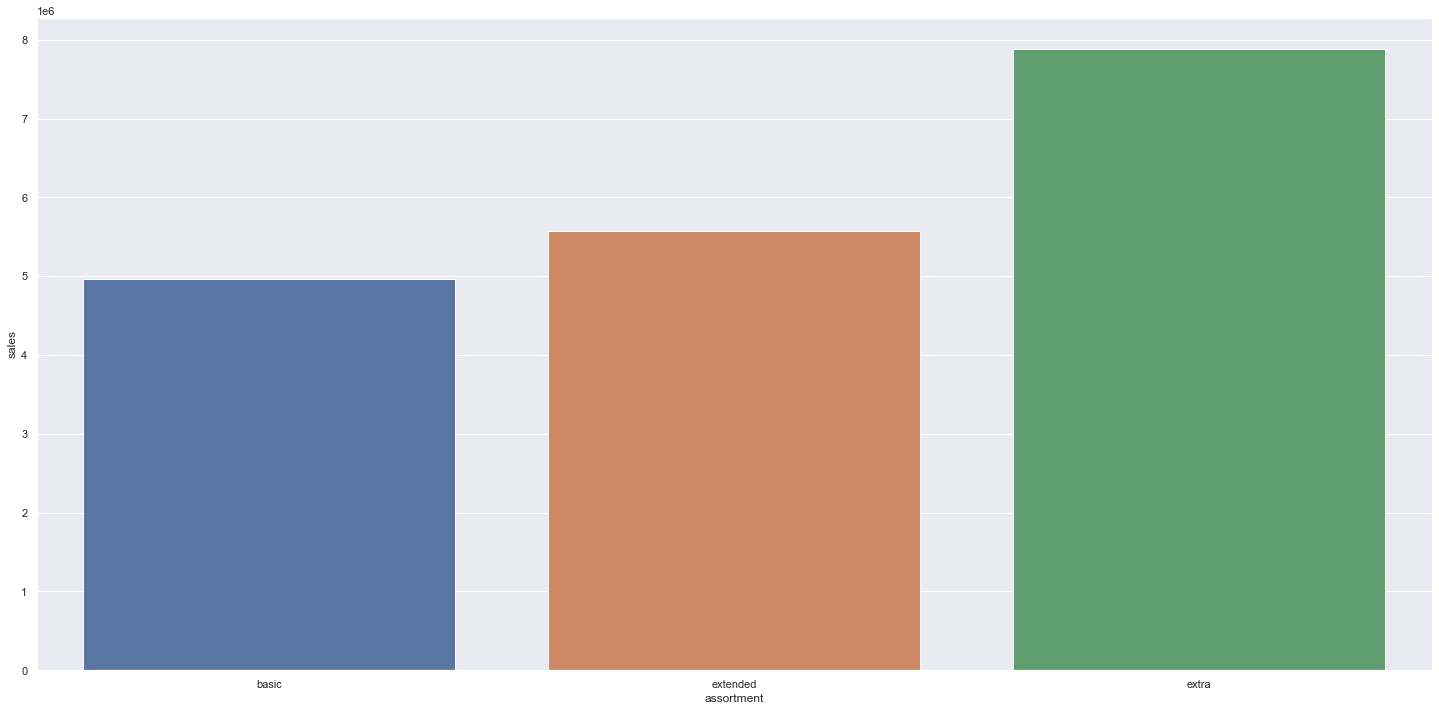

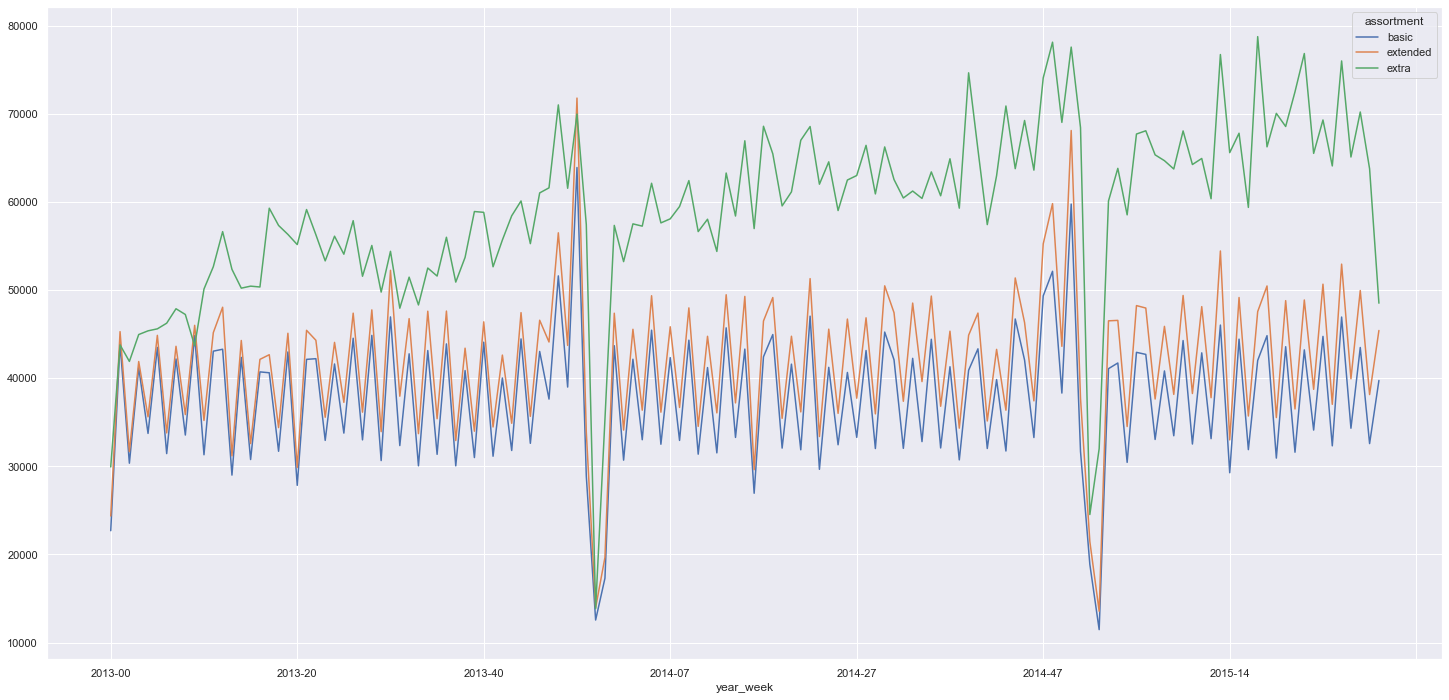

In [36]:
aux1 = df4[['assortment','sales','store']].groupby(['store','assortment']).sum().reset_index().groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales', data = aux1)  # mostra média de vendas das loja por assortment

# QUANTIDADE DE VENDAS MÉDIAS POR LOJA EM EXTRA: 7.882.923 (ao longo do tempo total)
# QUANTIDADE DE VENDAS MÉDIAS POR LOJA EM BASIC: 4.967.538 (ao longo do tempo total)

aux2 = df4[['year_week','assortment', 'sales','store']].groupby(['year_week','assortment','store']).sum().reset_index().groupby(['year_week','assortment']).mean().reset_index()
aux2.pivot(index='year_week', columns='assortment', values = 'sales').plot()

# quantidade de vendas médias por loja em cada dia, separados pro assortment 


### **H2** Lojas com competidores mais distantes deveriam vender mais.
**Falso** Há uma correlação próximo de zero, mas negativa, o que mostra que quanto mais distante vendem menos, de maneira não significativa.

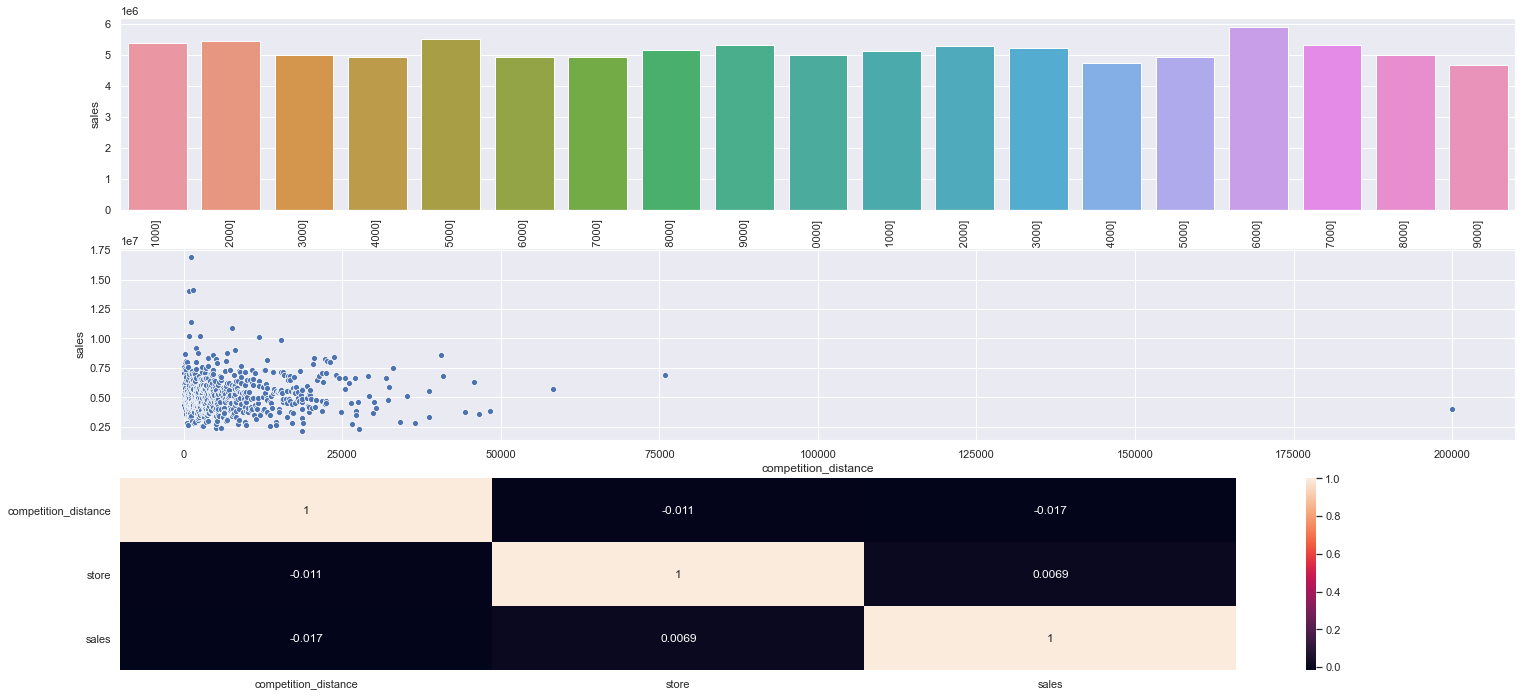

In [37]:
aux1 = df4[['competition_distance','sales','store']].groupby(['store','competition_distance']).sum().reset_index().groupby('competition_distance').mean().reset_index()

bi = list(np.arange(0,20000,1000))

aux1['competition_distance_binned'] = pd.cut(x = aux1['competition_distance'], bins=bi)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').mean().reset_index()

subplot(3,1,1)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation = 90);

subplot(3,1,2)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

subplot(3,1,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot=True)

### **H3** Lojas com competidores à mais tempo deveriam vender mais.
**Falso** lojas com competidores há mais tempo vendem levemente menos.
Há alguns outliers que deixam a correlação positiva, mas deveria ser negativa

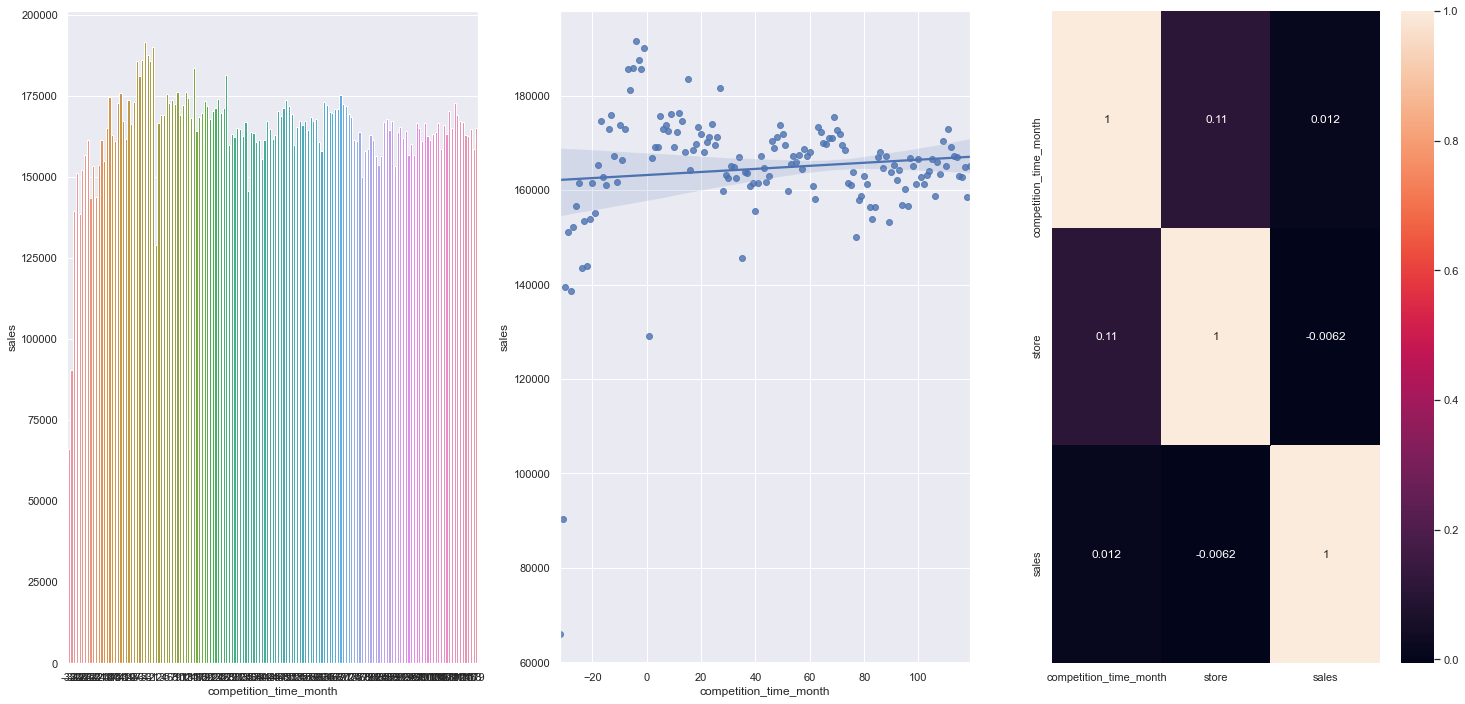

In [38]:


aux1 = df4[['competition_time_month', 'sales','store']].groupby(['store','competition_time_month']).sum().reset_index().groupby('competition_time_month').mean().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

plt.subplot(1,3,1)
sns.barplot(x='competition_time_month', y ='sales', data = aux2)
#plt.xticks(rotation = 90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data = aux2)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H4.** Lojas com promoções ativas por mais temmpo deveriam vender mais. DO H4 ATÉ O H6 ACHO QUE ESTÁ ERRADA POIS NÃO CONSIDERA SALES MÉDIO/LOJA E SIM SALES ABSOLUTO (PODE TER UM PICO DE SALES NÃO PQ A LOJA VENDE MAIS, MAS SIM PQ TEM UMA QUANTIDADE MAIOR DE LOJAS COM AQUELA QTDE DE DIAS DE PROMOÇÃO ): REFAZER

**Falsa** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção.



<ipython-input-39-bdb5765bdf80>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(grid[1,0])


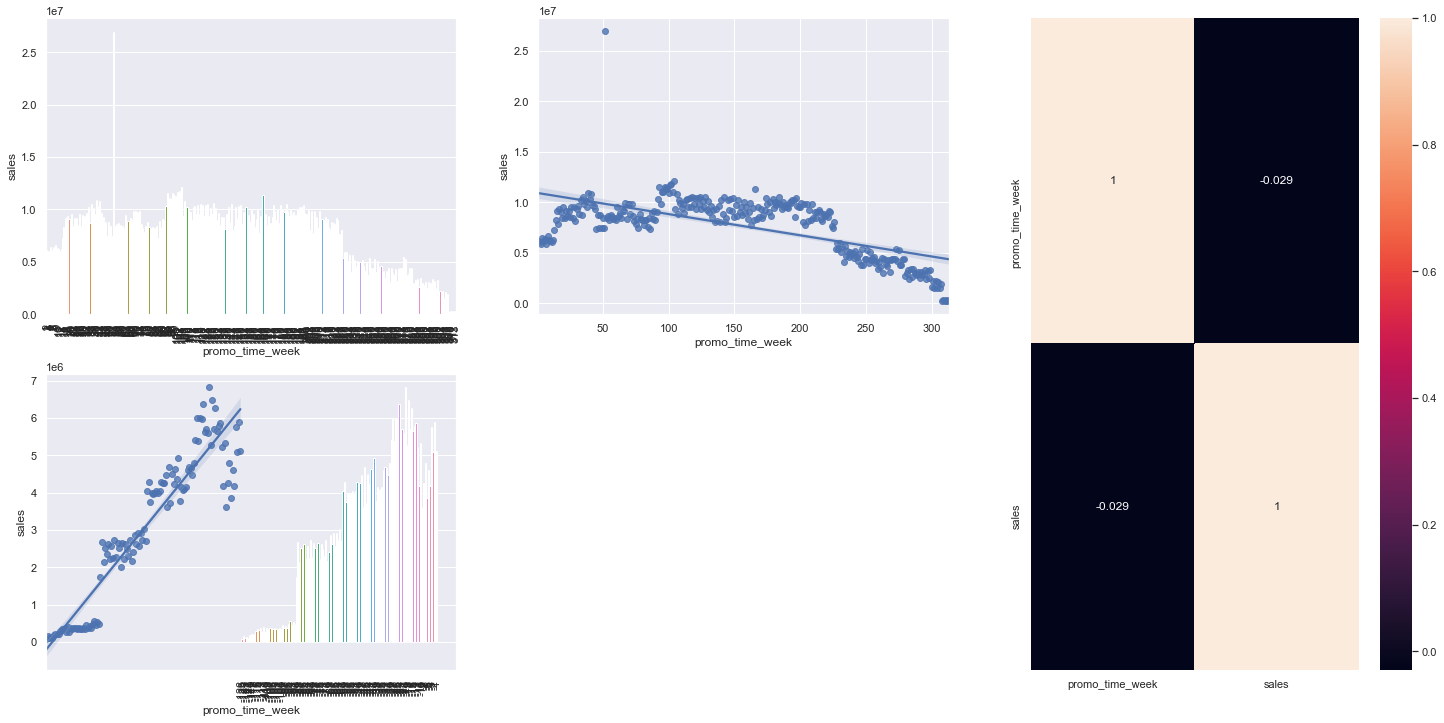

In [39]:
aux1 = df4[['promo_time_week', 'sales']].groupby ('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot(x = 'promo_time_week', y='sales', data=aux2);
plt.xticks(rotation = 90);

plt.subplot( grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data = aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] <0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data = aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[1,0])
sns.regplot(x='promo_time_week', y='sales', data = aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>



### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**Falsa** Lojas com mais promoções consecutivas vendem menos

In [40]:
a = df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()
a.sort_values(by=['sales'], inplace=True)
a

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


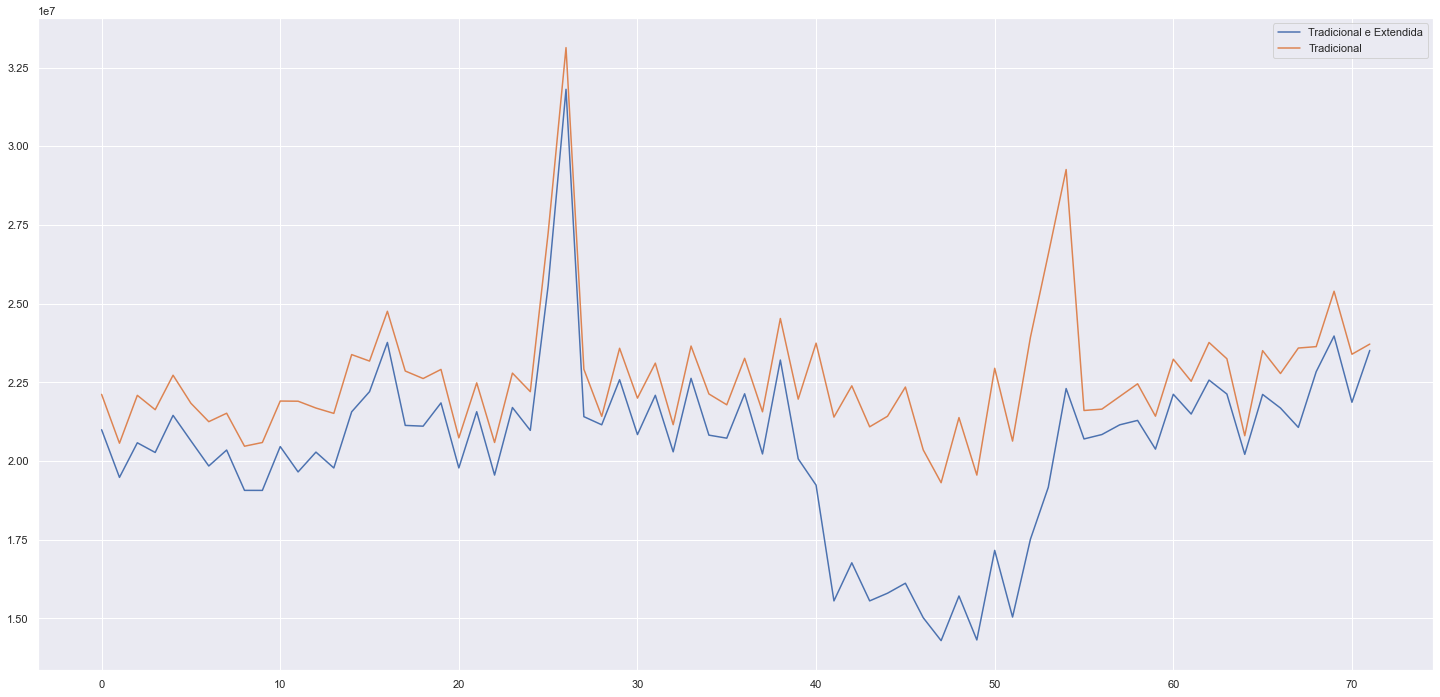

In [41]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional e Extendida', 'Tradicional']);

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**Falsa** Lojas abertas durante o feriado de natal vendem menos que nos outros feriados

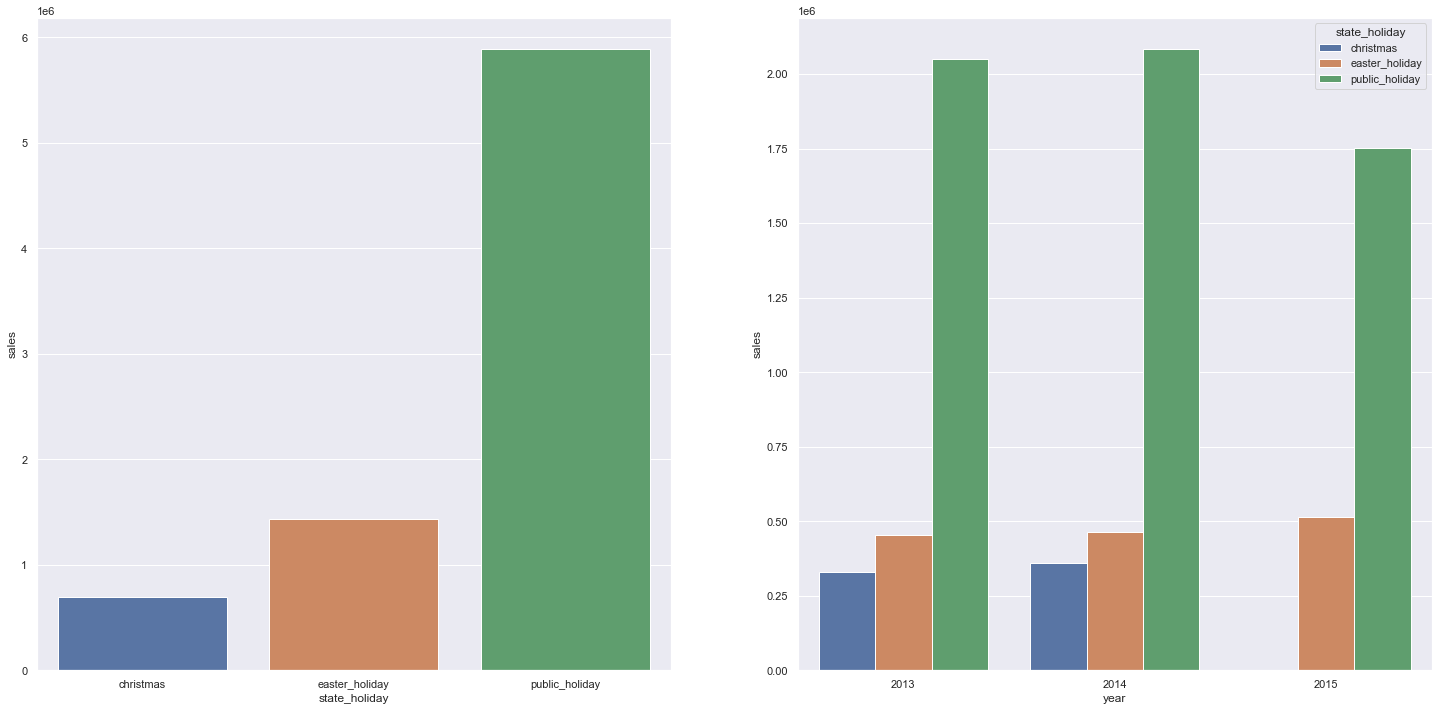

In [42]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data = aux1);

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales',hue = 'state_holiday', data = aux2);

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**Verdadeira**


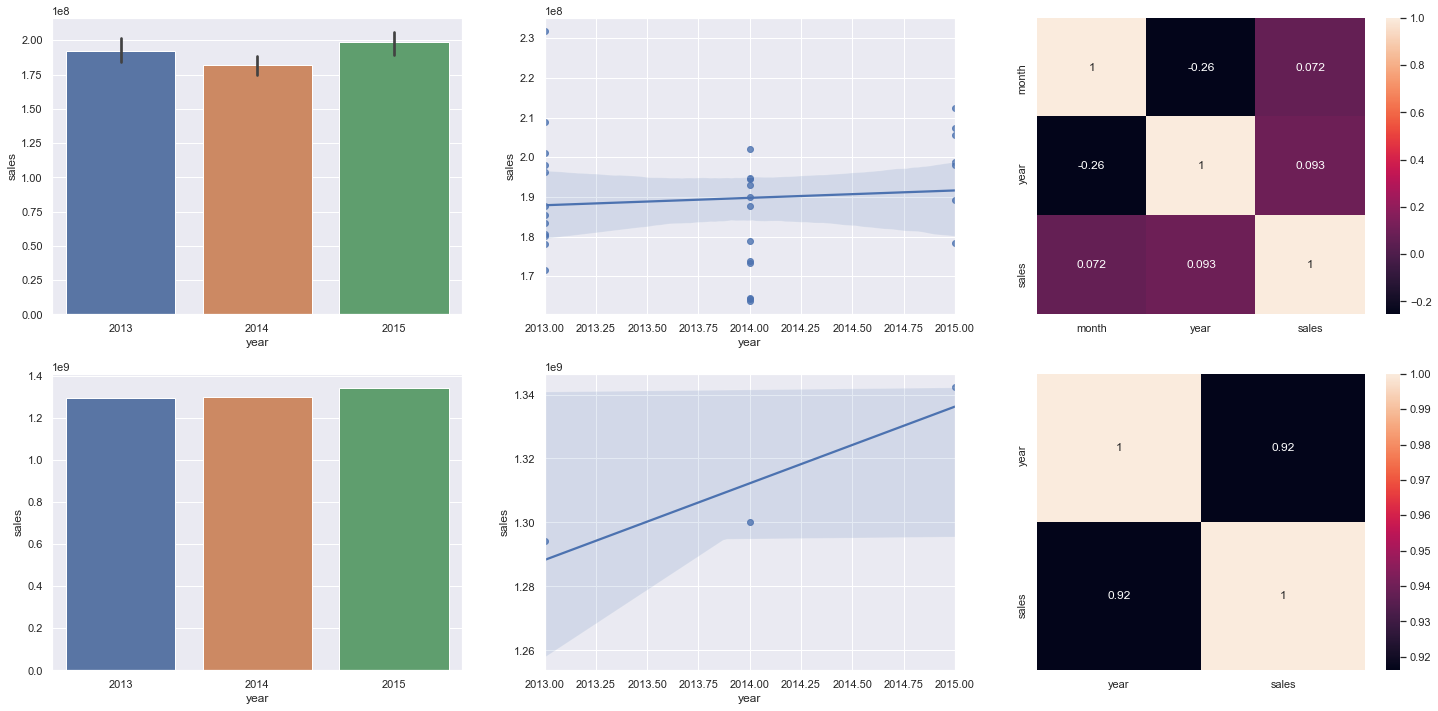

In [43]:
aux1 = df4[['month','sales','year']].groupby(['month','year']).sum().reset_index()

plt.subplot(2,3,1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(2,3,2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(2,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
#venda média/mês a cada ano

max_week = max(df4[df4['year'] == 2015 ]['week_of_year'])-1
aux2 = df4[df4['week_of_year'] <= max_week ][['year', 'sales']].groupby( 'year' ).sum().reset_index()


plt.subplot( 2, 3, 4 )
sns.barplot( x='year', y='sales', data=aux2 );

plt.subplot( 2, 3, 5 )
sns.regplot( x='year', y='sales', data=aux2 );

plt.subplot( 2, 3, 6 )
sns.heatmap( aux2.corr( method='pearson' ), annot=True );
# total de vendas em cada ano até a quantidade de semanas que temos em 2015

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**Falso** não há grandes alterações


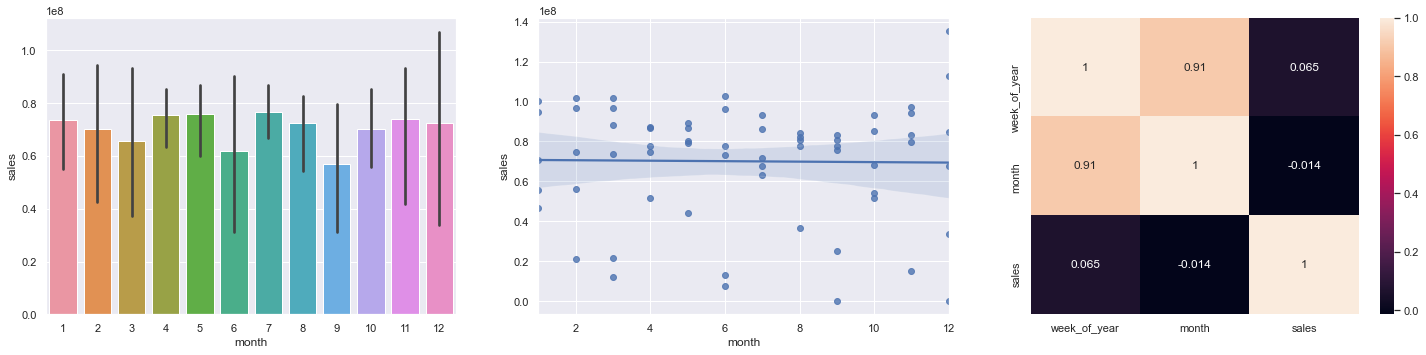

In [44]:
ax = df4[df4['year'] != 2015]
aux1 = ax[['week_of_year','sales','month']].groupby(['week_of_year','month']).sum().reset_index()

plt.subplot(2,3,1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(2,3,2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(2,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
#venda média/mês durante os anos de 2013 e 2014, 2015 não possui dados a partir da 30º semana do ano



In [45]:
aux2.head(10)

,year,sales
0,2013,1294305297
1,2014,1300114206
2,2015,1342268720


### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês
**Falso** vende menos


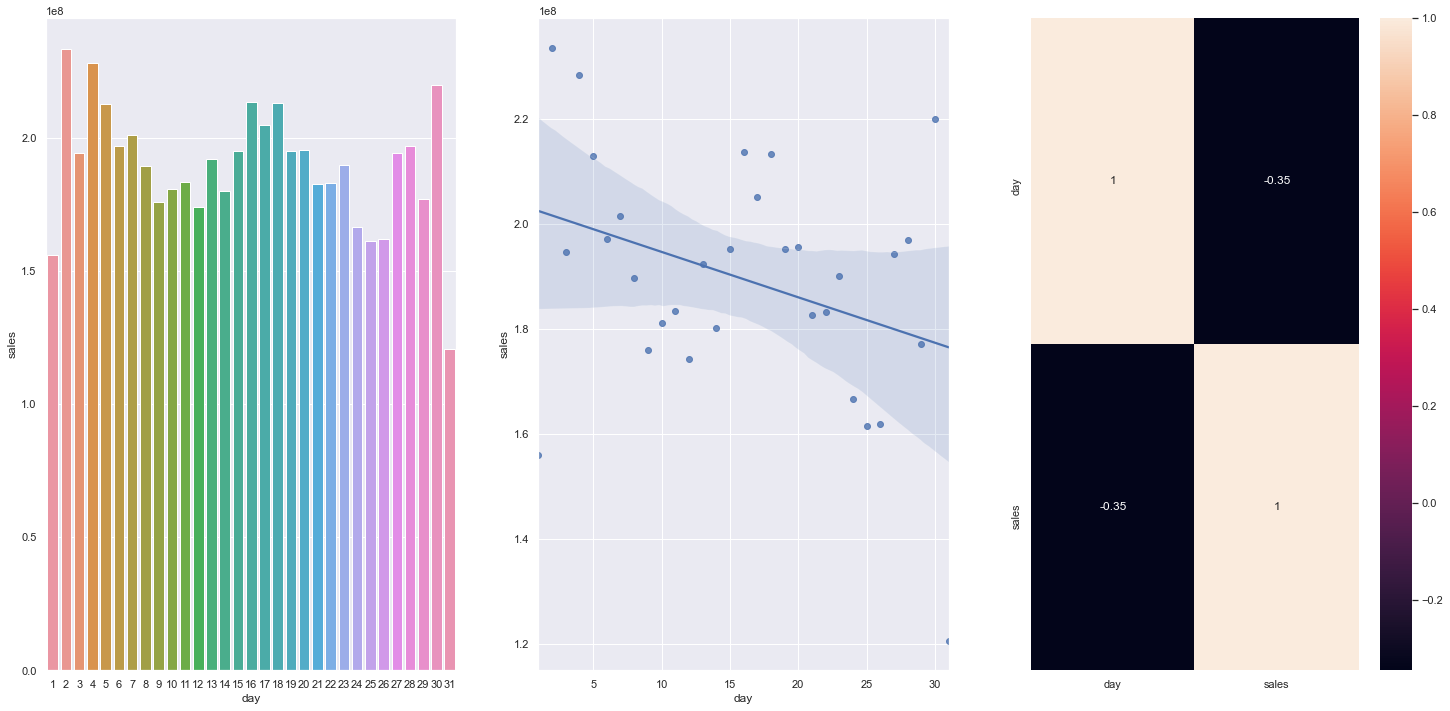

In [46]:
aux1 = df4[['sales','day']].groupby(['day']).sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)


### **H11.** Lojas deveriam vender menos aos finais de semana
**Verdadeiro**


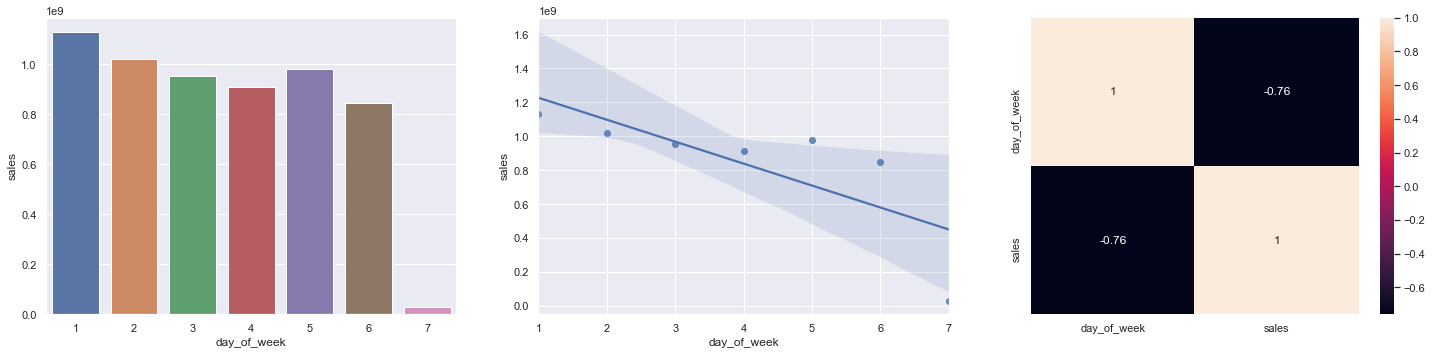

In [47]:
aux1 = df4[['sales','day_of_week']].groupby(['day_of_week']).sum().reset_index()

plt.subplot(2,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(2,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(2,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H12.** Lojas deveriam vender menos durantes feriados escolares

**NÃO ACHO NECESSÁRIO VALIDAR ESTA HIPÓTESE, TALVEZ NO PRÓXIMO CICLO**

### 4.2.1 Resumo das hipoteses

In [48]:
tab = [['hipoteses','conclusao','relevancia'],
       ['H1','Verdadeiro','Baixa'],
       ['H2','Falsa','Média'],
       ['H3','Falsa','Média'],
       ['H4','Falsa','Baixa'],
       ['H5','-','-'],
       ['H6','Falsa','Baixa'],
       ['H7','Falsa','Média'],
       ['H8','Verdadeiro','Baixa'],
       ['H9','Falsa','Baixa'],
       ['H10','Falsa','Baixa'],
       ['H11','Verdadeiro','Alta'],
       ['H12','-','-'],    
    ] 
print(tabulate(tab, headers='firstrow'))

hipoteses    conclusao    relevancia
-----------  -----------  ------------
H1           Verdadeiro   Baixa
H2           Falsa        Média
H3           Falsa        Média
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Média
H8           Verdadeiro   Baixa
H9           Falsa        Baixa
H10          Falsa        Baixa
H11          Verdadeiro   Alta
H12          -            -


## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

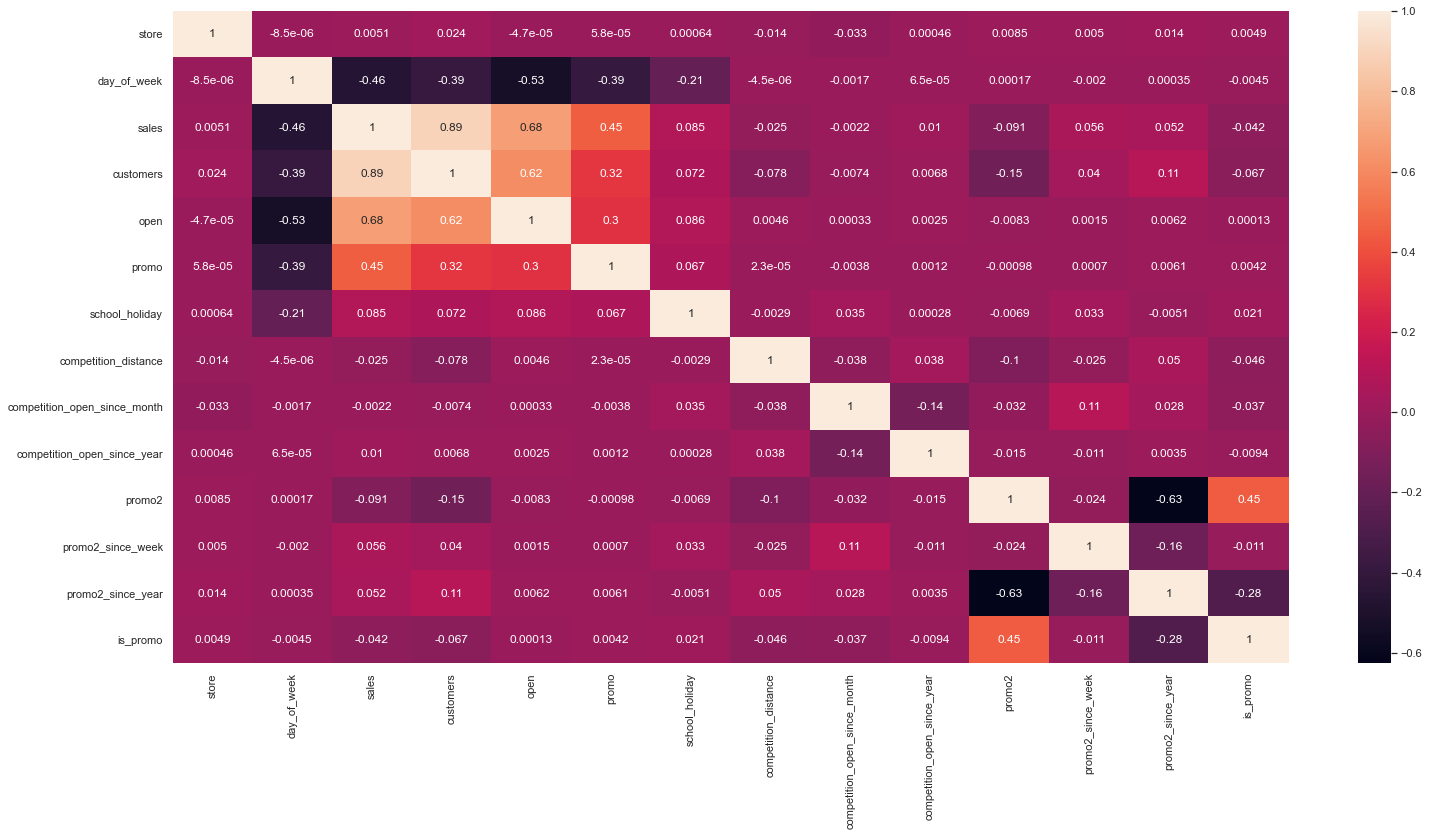

In [49]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2 Categorical Attributes

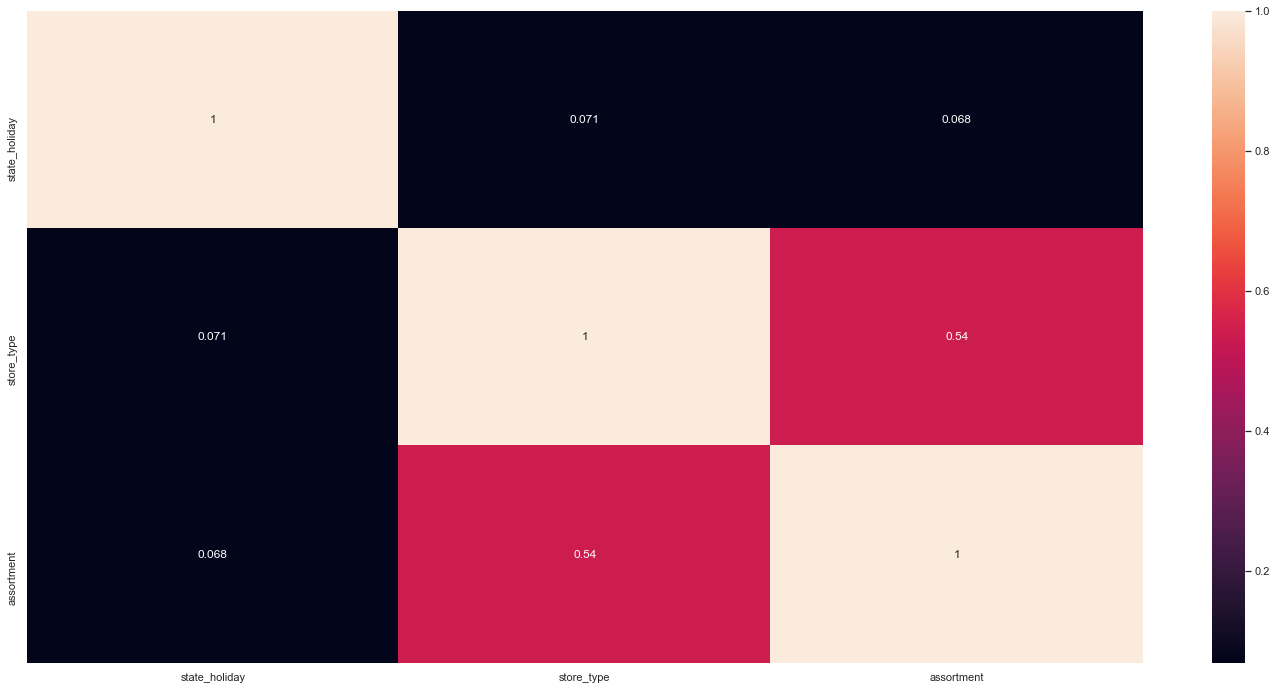

In [50]:
a = df4.select_dtypes(include = 'object')

a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday':[a1,a2,a3],
              'store_type':[a4,a5,a6],
              'assortment':[a7,a8,a9]})

d = d.set_index(d.columns)

sns.heatmap(d, annot = True);

# 5.0 Data Preparation

In [51]:
df5 = df4.copy()

## 5.1 Normalização

Observando as distribuições das variáveis numéricas em 4.1.2, é visível que nenhuma tem distribuição próxima da normal, o que deixaria a normalização ruim

## 5.2 Rescaling

In [52]:
a = df5.select_dtypes(include=['int64', 'float64'])

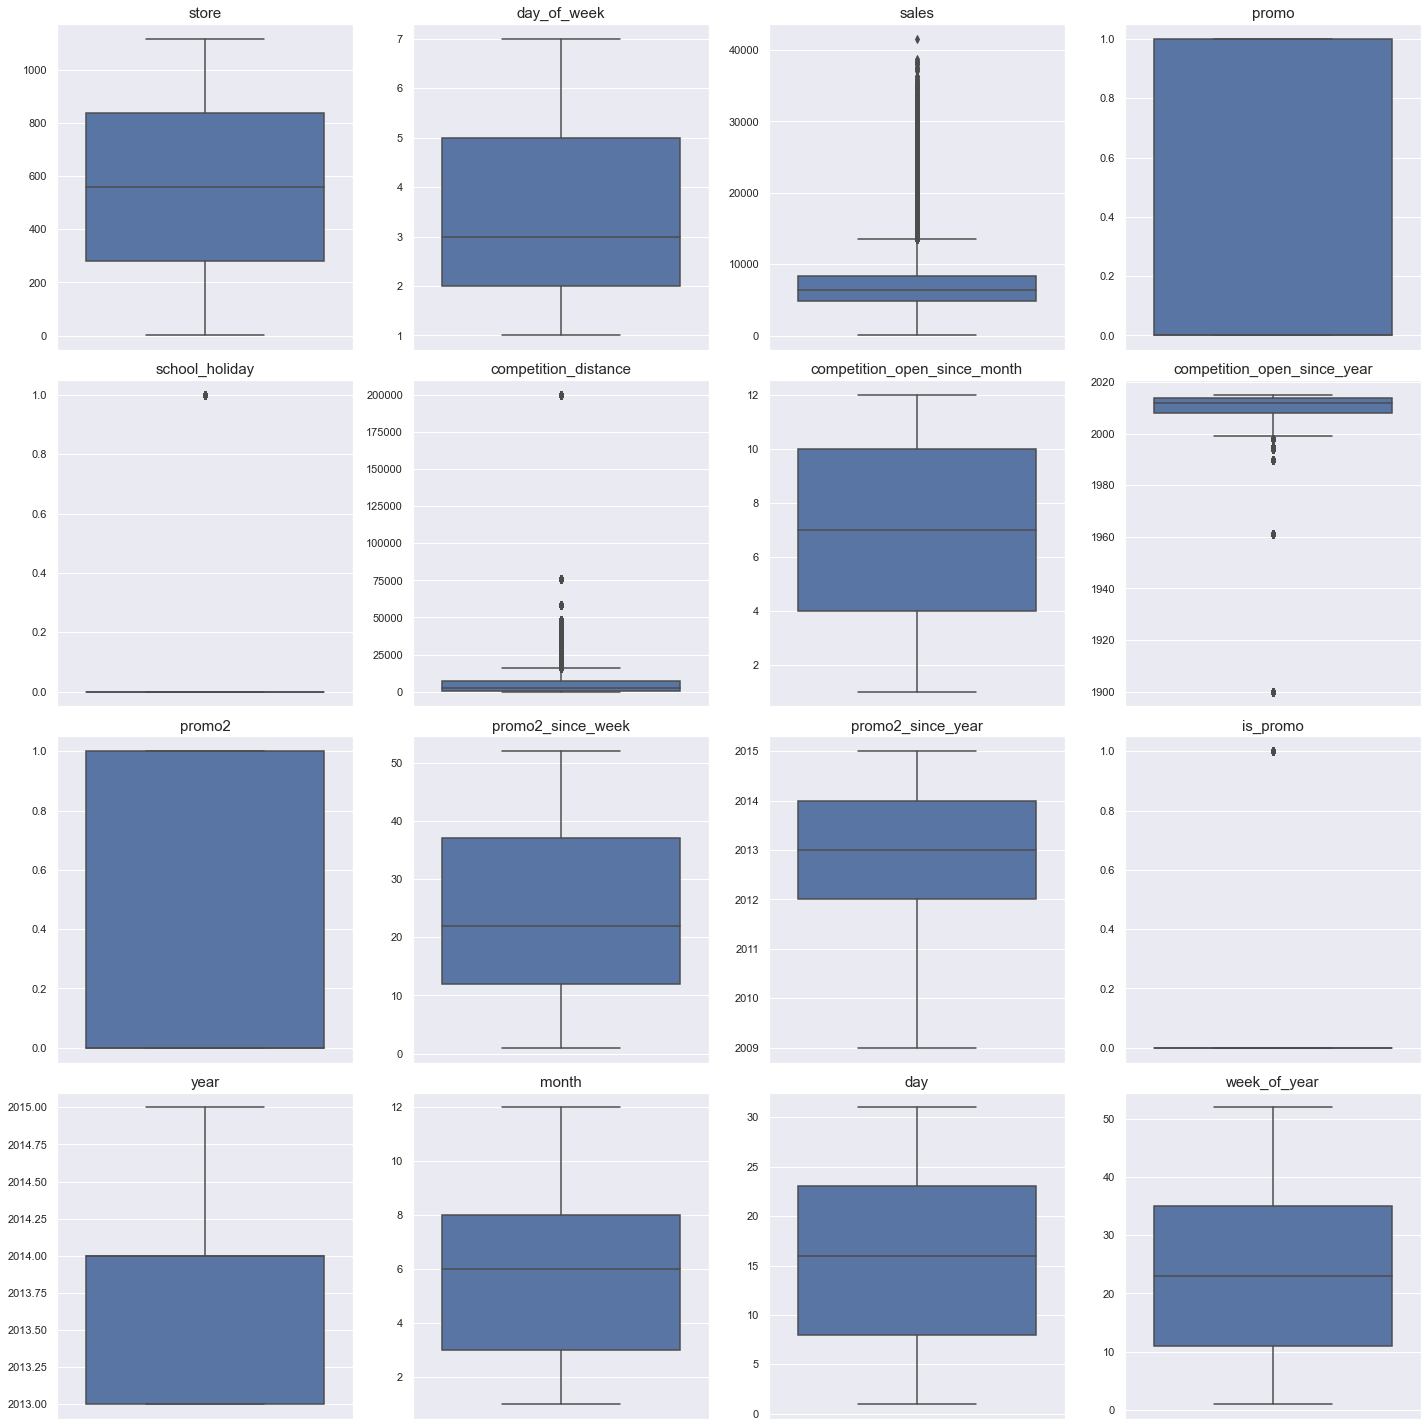

In [53]:
variables = a.columns.tolist()

f, axes = plt.subplots(4, 4, figsize = (20, 20))
for var, ax in zip(variables, f.axes):

  b = sns.boxplot(y = var, data = a, ax = ax)
  b.axes.set_title(var,fontsize = 15)
  b.set_ylabel("")

plt.tight_layout()
plt.show()

In [54]:
rs = RobustScaler()
mms = MinMaxScaler()

# competitoon distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
# year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3 Transformação

### 5.3.1 Encoding

In [55]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix =['state_holiday'], columns = ['state_holiday'])

# store_type -  Label Encoding (não se sabe se existe ordem ou coisa do tipo)
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic':1, 'extra':2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation


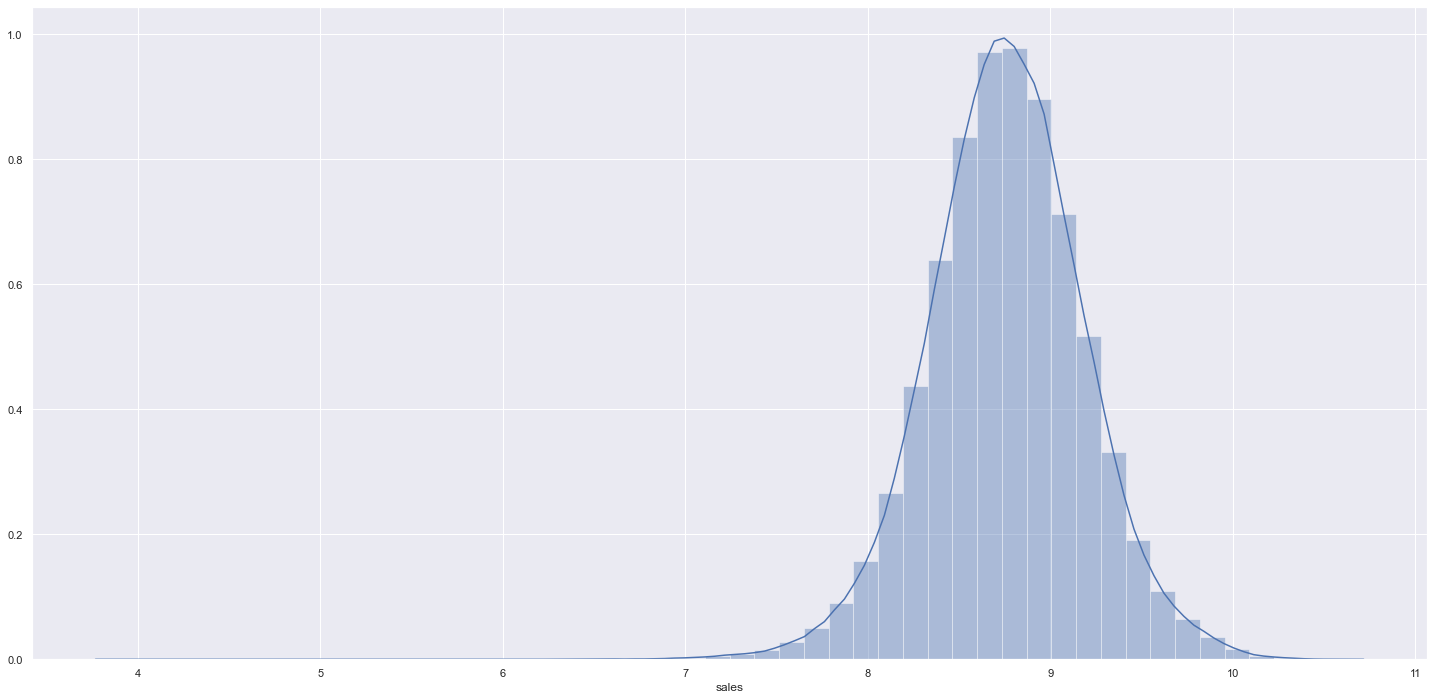

In [56]:
df5['sales'] = np.log1p(df5['sales'])
sns.distplot(df5['sales'])

### 5.3.3 Nature Transformation

In [57]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi/7 ) ) )
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) )
# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/30 ) ) )
# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi/52 ) ) )


In [58]:
df5.head(5)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0 Feature Selection

In [59]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [60]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [61]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7) # já que quero testar 6 semanas a frente

Timestamp('2015-06-19 00:00:00')

In [62]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

## 6.2 Boruta as feature selector

In [63]:

# training and test dataset for Boruta
#X_train_n = X_train.drop(['date', 'sales'], axis = 1).values
#y_train_n = y_train.values.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs = -1)

# define Boruta
#boruta = BorutaPy(rf, n_estimators = 'auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1 Best features from boruta

In [64]:
'''
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop(['date','sales'], axis = 1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-64-8186a04fabe8>, line 9)

## 6.3 Manual Feature Selection

In [81]:
cols_selected_boruta = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin', # added
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin', # added
 'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 Machine Learning Modelling

In [99]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1 Average Model

In [84]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()


# prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns ={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how = 'left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [85]:
# Model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [102]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model - Lasso

In [88]:
# Model
lrr = Lasso(alpha = 0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Linear Regression Regularized Model - Lasso - Cross Validation

In [103]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regressor

In [90]:
# Model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train) # aumentar para 2500 ou 3000 posteriormente se der

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


### 7.4.1 Random Forest Regressor - Cross Validation

In [104]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17


## 7.5 XGBoost Regressor

In [97]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytree=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.6064,0.949503,7330.742181


### 7.5.1 XGBoost Regressor - Cross Validation

In [105]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7047.97 +/- 587.65,0.95 +/- 0.0,7714.03 +/- 688.72


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [98]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result,xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6683.606400,0.949503,7330.742181


### Real Performance - Cross Validation

In [106]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv.sort_values('RMSE')

KeyError: 'RMSE'